# Use this notebook to look up how do I X? with Hamilton.

If you need more specifics we direct you to https://hamilton.dagworks.io for more documentation.

In [71]:
# validate what is the current working directory!
!pwd

/Users/stefankrawczyk/dagworks/hamilton-tutorials/2023-08-08/reference


In [92]:
from IPython.display import clear_output

Uncomment and run the cell below if you are in a Google Colab environment. It will:

1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the example
7. Install requirements.
8. This means that any modifications will be saved, and you won't lose them if you close your browser.

In [70]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton-tutorials/
## 6. Move your current directory to the example
# %cd hamilton-tutorials/2023-08-08/reference
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
## To check your current working directory you can type `!pwd` in a cell and run it.

In [ ]:
!pip install -r requirements.txt

In [53]:
import pandas as pd
import pandera as pa

## Old way vs new way
A quick overview of the paradigm from a before and after perspective.

In [3]:
def load_data() -> pd.DataFrame:
    return pd.DataFrame({
        'spend': [100.0, 200.0, 300.0, 400.0, 500.0],
        'signups': [10, 20, 30, 40, 50]
    })


In [4]:
# Old Way -- instead of this:
data = load_data()
data['avg_3wk_spend'] = data['spend'].rolling(3).mean()
data['spend_per_signup'] = data['spend']/data['signups']
spend_mean = data['spend'].mean()
data['spend_zero_mean'] = data['spend'] - spend_mean
spend_std_dev = data['spend'].std()
data['spend_zero_mean_unit_variance'] = data['spend_zero_mean']/spend_std_dev
print(data.to_string())

   spend  signups  avg_3wk_spend  spend_per_signup  spend_zero_mean  spend_zero_mean_unit_variance
0  100.0       10            NaN              10.0           -200.0                      -1.264911
1  200.0       20            NaN              10.0           -100.0                      -0.632456
2  300.0       30          200.0              10.0              0.0                       0.000000
3  400.0       40          300.0              10.0            100.0                       0.632456
4  500.0       50          400.0              10.0            200.0                       1.264911


In [5]:
%%writefile new_way.py
# new_way.py --- %%writefile is a quick way to write a module too.
import pandas as pd
def avg_3wk_spend(spend: pd.Series) -> pd.Series:
  """Rolling 3 day average spend."""
  return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
  """The cost per signup in relation to spend."""
  return spend / signups


def spend_mean(spend: pd.Series) -> float:
  """Shows function creating a scalar. In this case it computes the mean of the entire column."""
  return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
  """Shows function that takes a scalar. In this case to zero mean spend."""
  return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
  """Function that computes the standard deviation of the spend column."""
  return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
  """Function showing one way to make spend have zero mean and unit variance."""
  return spend_zero_mean / spend_std_dev


Overwriting new_way.py


In [8]:
from hamilton import driver
import new_way
dr = driver.Driver({}, new_way)
outputs = ["spend",
           "signups",
           new_way.avg_3wk_spend,
           new_way.spend_per_signup,
           new_way.spend_zero_mean,
           new_way.spend_zero_mean_unit_variance]
result = dr.execute(
  outputs,
  inputs=load_data().to_dict(orient="series")
)
print(result.to_string())


   spend  signups  avg_3wk_spend  spend_per_signup  spend_zero_mean  spend_zero_mean_unit_variance
0  100.0       10            NaN              10.0           -200.0                      -1.264911
1  200.0       20            NaN              10.0           -100.0                      -0.632456
2  300.0       30          200.0              10.0              0.0                       0.000000
3  400.0       40          300.0              10.0            100.0                       0.632456
4  500.0       50          400.0              10.0            200.0                       1.264911


## Driver: Changing the "type" of what execute() returns
Use this is if you don't want a dataframe as a result. Hamilton gives you flexibility to adjust and change the what the return type is.

In [26]:
from hamilton import base  #  base houses a few other ways to construct results.
from hamilton import driver
import new_way
# instantiate the right adapter & result builder.
dr2 = driver.Driver(
    {},
    new_way,
    # adjust adapter to change behavior
    adapter=base.SimplePythonGraphAdapter(base.DictResult())
)
outputs = ["spend",
           "signups",
           new_way.avg_3wk_spend,
           new_way.spend_per_signup,
           new_way.spend_zero_mean,
           new_way.spend_zero_mean_unit_variance]
result = dr2.execute(
  outputs,
  inputs=load_data().to_dict(orient="series")
)
print(result)  # this is now a dictionary!

{'spend': 0    100.0
1    200.0
2    300.0
3    400.0
4    500.0
Name: spend, dtype: float64, 'signups': 0    10
1    20
2    30
3    40
4    50
Name: signups, dtype: int64, 'avg_3wk_spend': 0      NaN
1      NaN
2    200.0
3    300.0
4    400.0
Name: spend, dtype: float64, 'spend_per_signup': 0    10.0
1    10.0
2    10.0
3    10.0
4    10.0
dtype: float64, 'spend_zero_mean': 0   -200.0
1   -100.0
2      0.0
3    100.0
4    200.0
Name: spend, dtype: float64, 'spend_zero_mean_unit_variance': 0   -1.264911
1   -0.632456
2    0.000000
3    0.632456
4    1.264911
Name: spend, dtype: float64}


## Driver using overrides
Use overrides in development, or using prior results to inject values into the DAG.

In [27]:
result = dr.execute(
  outputs,
  inputs=load_data().to_dict(orient="series"),
  overrides={"spend_std_dev": 0.3}  # this will inject this value and short circuit DAG walking.
)
print(result)  # see values have changed

   spend  signups  avg_3wk_spend  spend_per_signup  spend_zero_mean  \
0  100.0       10            NaN              10.0           -200.0   
1  200.0       20            NaN              10.0           -100.0   
2  300.0       30          200.0              10.0              0.0   
3  400.0       40          300.0              10.0            100.0   
4  500.0       50          400.0              10.0            200.0   

   spend_zero_mean_unit_variance  
0                    -666.666667  
1                    -333.333333  
2                       0.000000  
3                     333.333333  
4                     666.666667  


## Driver: reusing the same Driver multiple times
Shows that you can reuse the same driver in a for loop passing different inputs. Use this for simulations, chunking over data, etc.

In [28]:
import random
data_chunks = [
    {"spend": pd.Series([random.random() * random.randint(1, 100) for r in range(0,5)]),
     "signups": pd.Series([random.randint(1, 1000) for __ in range(0,5)])
     } for _ in range(0,5)
]
for chunk in data_chunks:
    result = dr.execute(
      outputs,
      inputs=chunk,
    )
    print(result)

       spend  signups  avg_3wk_spend  spend_per_signup  spend_zero_mean  \
0  43.925551      305            NaN          0.144018        24.768071   
1   1.744286      881            NaN          0.001980       -17.413194   
2  44.697686      739      30.122508          0.060484        25.540206   
3   5.327245      150      17.256406          0.035515       -13.830235   
4   0.092630       50      16.705854          0.001853       -19.064850   

   spend_zero_mean_unit_variance  
0                       1.074913  
1                      -0.755718  
2                       1.108423  
3                      -0.600220  
4                      -0.827398  
       spend  signups  avg_3wk_spend  spend_per_signup  spend_zero_mean  \
0  60.845175      356            NaN          0.170913        19.067889   
1  25.515806      156            NaN          0.163563       -16.261480   
2  14.752644      621      33.704542          0.023756       -27.024641   
3  34.211227      552      24.826559   

## Visualizing the DAG

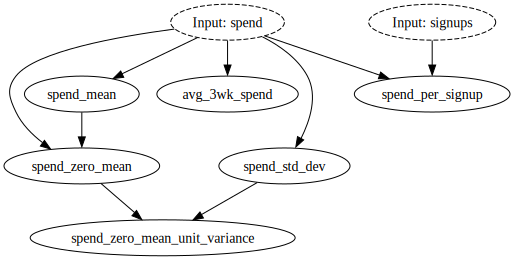

In [91]:
from hamilton import driver
import new_way

# Create the driver -- passing in an empty config and the functions module
dr = driver.Driver({}, new_way)
# display everythin in new_way
dr.display_all_functions(None)

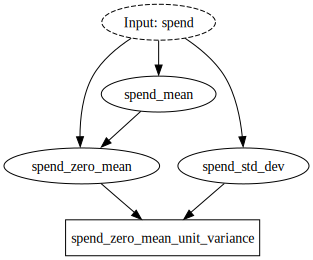

In [90]:
# display only the path we care about:
dr.visualize_execution(
    ["spend_zero_mean_unit_variance"],
    None, None, inputs=load_data().to_dict(orient="series"))

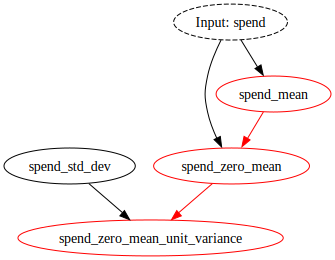

In [24]:
# highlight path between two nodes
dr.visualize_path_between("spend_mean", "spend_zero_mean_unit_variance")

# Decorators
This next section will have decorator snippets

## @config.when
Use this to pull out `if/else` statements from your code, and have specific functions swapped out instead.

In [34]:
%%writefile config_example.py
import pandas as pd
from hamilton.function_modifiers import config

def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
  """The cost per signup in relation to spend."""
  return spend / signups

@config.when(lookback="long")
def acquisition_cost_rolling_mean__long(spend: pd.Series, specific_input_long: str) -> pd.Series:
  """Rolling 7 day average spend."""
  # specific_input_long just highlights that you can have a specific dependency unique to this
  # function.
  return spend.rolling(window=7, min_periods=1).mean()

@config.when(lookback="short")
def acquisition_cost_rolling_mean__short(spend: pd.Series) -> pd.Series:
  """Rolling 3 day average spend."""
  return spend.rolling(window=3,min_periods=1).mean()


Overwriting config_example.py


In [35]:
from hamilton import driver
import config_example
# we statically create a DAG with the "long" version.
dr = driver.Driver({"lookback" : "long",
                    "specific_input_long": "some_extra_input"}, config_example)
print(dr.execute(
  final_vars=["acquisition_cost_rolling_mean"],
  inputs=load_data().to_dict(orient="series")
))

   acquisition_cost_rolling_mean
0                          100.0
1                          150.0
2                          200.0
3                          250.0
4                          300.0


In [36]:
# we statically create a DAG with the "short" version -- not extra inputs needed.
dr = driver.Driver({"lookback" : "short"}, config_example)
print(dr.execute(
  final_vars=["acquisition_cost_rolling_mean"],
  inputs=load_data().to_dict(orient="series")
))

   acquisition_cost_rolling_mean
0                          100.0
1                          150.0
2                          200.0
3                          300.0
4                          400.0


## @parameterize
Use this if you want to programmatically create function definitions.

E.g. where things differ by a value (use "value"), or by the function "parameter" (use "source") that should be used as input.


In [44]:
%%writefile parameterize_example.py
import pandas as pd
from hamilton.function_modifiers import parameterize, value, source

@parameterize(
  acquisition_cost_rolling_mean_none={"window" : value(1)},
  acquisition_cost_rolling_mean_short={"window" : value(3)},
  acquisition_cost_rolling_mean_medium={"window" : value(5)},
  acquisition_cost_rolling_mean_long={"window" : value(7)}
)
def base_acquisition_cost_rolling_mean(spend: pd.Series, window: int) -> float:
  """Rolling 3 day average spend."""
  return spend.rolling(window=window, min_periods=1).mean()

@parameterize(
    acrmn_doubled={"input_source": source("acquisition_cost_rolling_mean_none")},
    acrms_doubled={"input_source": source("acquisition_cost_rolling_mean_short")},
    acrmm_doubled={"input_source": source("acquisition_cost_rolling_mean_medium")},
    acrml_doubled={"input_source": source("acquisition_cost_rolling_mean_long")}
)
def base_function_to_show_source_parameterization(input_source: float) -> float:
  """Doubles the {input_source}."""
  return input_source * 2


Overwriting parameterize_example.py


   acquisition_cost_rolling_mean_short  acquisition_cost_rolling_mean_long  acrms_doubled  acrml_doubled
0                                100.0                               100.0          200.0          200.0
1                                150.0                               150.0          300.0          300.0
2                                200.0                               200.0          400.0          400.0
3                                300.0                               250.0          600.0          500.0
4                                400.0                               300.0          800.0          600.0


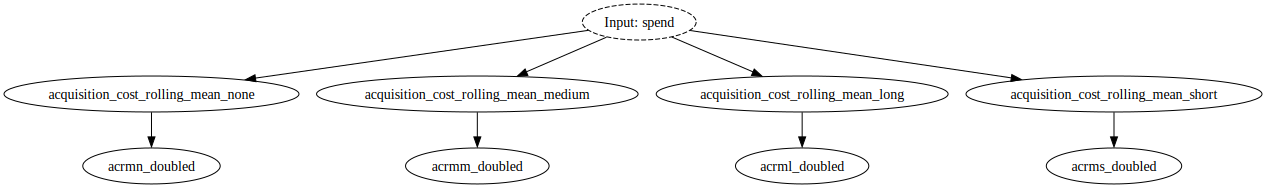

In [51]:
from hamilton import driver
import parameterize_example
dr = driver.Driver({}, parameterize_example)
result = dr.execute(
  [
      "acquisition_cost_rolling_mean_short",
      "acquisition_cost_rolling_mean_long",
      "acrms_doubled",
      "acrml_doubled",
  ],
  inputs=load_data().to_dict(orient="series")
)
# print result
print(result.to_string())
# and show what was define -- we only ran part of this DAG.
dr.display_all_functions(None)

## Runtime Data Quality checks with @check_output
With Hamilton you can annotate a function with an expectation. It will then run after that function is executed and check it. This is great having jobs fail quickly.

In [81]:
%%writefile check_output_example.py
import pandas as pd
import pandera as pa
import numpy as np

from hamilton.function_modifiers import check_output

# pandera doesn't operate over single values
@check_output(range=(20.0, 60.0), data_type=np.float64, importance="fail")
def age_mean(age: pd.Series) -> np.float64:
    """Average of age"""
    return age.mean()

# create pandera schema with expectations
age_zero_mean_schema = pa.SeriesSchema(
    np.float64,
    checks=[
        pa.Check.in_range(-120.0, 120.0),
    ],
    nullable=False,
)

# This doesn't seem to work when running from within a notebook...
# @check_output(schema=age_zero_mean_schema, importance="warn")
def age_zero_mean(age: pd.Series, age_mean: np.float64) -> pd.Series:
    """Zero mean of age"""
    return age - age_mean

# if __name__ == '__main__':
#     import check_output_example
#     from hamilton import driver
#     from hamilton.data_quality.base import DataValidationError
#     dr = driver.Driver({}, check_output_example)
#     try:
#         result = dr.execute(["age_zero_mean"],
#                             inputs={"age": pd.Series([1, 2, 3, 4, 5])})
#     except DataValidationError:
#         print("Caught DataValidationError")
#
#     result = dr.execute(["age_zero_mean"],
#                         inputs={"age": pd.Series([21, 22, 23, 24, 25])})
#     print(result.to_string())


Overwriting check_output_example.py


In [85]:
from hamilton import driver
import check_output_example
import importlib
importlib.reload(check_output_example)
dr = driver.Driver({}, check_output_example)
# this will run as expected
result = dr.execute(
  ["age_zero_mean"],
  inputs={
      "age": pd.Series([20, 30, 50, 60])
  }
)
print(result.to_string())
# this will fail because age isn't in range.
try:
    result = dr.execute(
      [check_output_example.age_zero_mean],
      inputs={
          "age": pd.Series([10, 11, 12, 13])
      }
    )
except Exception as e:
    print(f"As expected got a validation error: {e}")
print("done")

[age_mean:range_validator] validator failed. Message was: Data point 11.5 does not fall within acceptable range: (20.0, 60.0). Diagnostic information is: {'range': (20.0, 60.0), 'value': 11.5}.

Node age_mean encountered an error
Traceback (most recent call last):
  File "/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/hamilton-tutorials-py310/lib/python3.10/site-packages/hamilton/graph.py", line 481, in dfs_traverse
    value = adapter.execute_node(node_, kwargs)
  File "/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/hamilton-tutorials-py310/lib/python3.10/site-packages/hamilton/base.py", line 457, in execute_node
    return node.callable(**kwargs)
  File "/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/hamilton-tutorials-py310/lib/python3.10/site-packages/hamilton/function_modifiers/validation.py", line 84, in final_node_callable
    dq_base.act_fail_bulk(node_.name, failures)
  File "/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/hamilton-tutorials-py310/lib/python3.10/sit

   age_zero_mean
0          -20.0
1          -10.0
2           10.0
3           20.0
As expected got a validation error: ["[age_mean:range_validator] validator failed. Message was: Data point 11.5 does not fall within acceptable range: (20.0, 60.0). Diagnostic information is: {'range': (20.0, 60.0), 'value': 11.5}.\n"]
done


## @tag
Use this to annotated functions with extra metadata. You can then do some cool things and query the DAG and use them to determine what to request/compute, or determine who to contact, or build a governance solution on top of, etc.

In [68]:
%%writefile tag_example.py
import pandas as pd
from hamilton.function_modifiers import tag

@tag(feature="true")
def avg_3wk_spend(spend: pd.Series) -> pd.Series:
  """Rolling 3 day average spend."""
  return spend.rolling(3).mean()

@tag(feature="true")
def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
  """The cost per signup in relation to spend."""
  return spend / signups

def spend_mean(spend: pd.Series) -> float:
  """Shows function creating a scalar. In this case it computes the mean of the entire column."""
  return spend.mean()

def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
  """Shows function that takes a scalar. In this case to zero mean spend."""
  return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
  """Function that computes the standard deviation of the spend column."""
  return spend.std()

@tag(feature="true")
def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
  """Function showing one way to make spend have zero mean and unit variance."""
  return spend_zero_mean / spend_std_dev

Writing tag_example.py


In [69]:
from hamilton import driver
import tag_example
dr = driver.Driver({}, tag_example)
outputs = [var.name for var in dr.list_available_variables()
           if var.tags.get("feature") == "true"]
result = dr.execute(
    outputs,
    inputs=load_data().to_dict(orient="series")
)
print(result.to_string())

   avg_3wk_spend  spend_per_signup  spend_zero_mean_unit_variance
0            NaN              10.0                      -1.264911
1            NaN              10.0                      -0.632456
2          200.0              10.0                       0.000000
3          300.0              10.0                       0.632456
4          400.0              10.0                       1.264911


# Module Composability
You can manage different DAG shapes quite easily.
You can do so via @config.when, or via different modules you pass into the driver, or both.


In [86]:
# TODO: Fill in code live if needed.

# CachingAdapter
This is useful for local iteration and you want to save an "expensive" step and not have to compute it again. You can also use it in production and extend it.

In [88]:
# TODO: walk through caching adapter code.
# for this to work, you need to annotate functions with `tag(cache="TYPE")`.
import pathlib
from hamilton.experimental import h_cache
import new_way

config = {}
cache_path = "tmp"
pathlib.Path(cache_path).mkdir(exist_ok=True)
adapter = h_cache.CachingGraphAdapter(cache_path, base.PandasDataFrameResult())
dr = driver.Driver(config, new_way, adapter=adapter)
output_columns = [
    new_way.avg_3wk_spend,
    new_way.spend_per_signup,
    new_way.spend_zero_mean_unit_variance,
]

df = dr.execute(output_columns, inputs=load_data().to_dict(orient="series"))
print(df.to_string())

   avg_3wk_spend  spend_per_signup  spend_zero_mean_unit_variance
0            NaN              10.0                      -1.264911
1            NaN              10.0                      -0.632456
2          200.0              10.0                       0.000000
3          300.0              10.0                       0.632456
4          400.0              10.0                       1.264911
